___


<a href='https://aims.edu.gh/'> <img src='http://gh.nexteinstein.org/wp-content/uploads/sites/15/2016/09/logo.jpg' /></a>
___
# Foundations of Machine Learning 

## Generative and Discriminative Modelling Project

The objective of this project is to compare the perfomance of Naive Bayes, Gaussian Discriminant Analysis and Logistic regression on different data sizes. A detailed descripion of the instructions is shown below.

<img src="instructions.png">


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

### Load data


In [2]:
#import both traing and test
drugs_train = pd.read_csv('drugLibTrain_raw.tsv',delimiter='\t')
drugs_test = pd.read_csv('drugLibTest_raw.tsv',delimiter='\t')

## Data pre-processing

In [3]:
#drop first column of data as it is not important
drugs_train = drugs_train.drop('Unnamed: 0',axis=1)
drugs_test = drugs_test.drop('Unnamed: 0',axis=1)

#combine both training and test and shuffle
drugs_combined = pd.concat([drugs_train,drugs_test],axis=0)

#Shuffle data to avoid any biasness
drugs_combined = shuffle(drugs_combined, random_state = 1)

In [4]:
target=drugs_combined['rating']
target=target-1 #shift indices to start from zero
target=target.values

In [5]:
#features_full=drugs_combined['urlDrugName']+drugs_combined['effectiveness']+drugs_combined['sideEffects']+drugs_combined['condition']+drugs_combined['benefitsReview']+drugs_combined['sideEffectsReview']+drugs_combined['commentsReview']

In [33]:
features_full=drugs_combined['effectiveness']+drugs_combined['sideEffects'] #using less variable

In [34]:
features_full = features_full.apply(lambda x: str(x)) #convert all features to strings

## Feature Extraction

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

#create instance of countvectorizer 
vectorizer = CountVectorizer(stop_words='english',binary=True,max_features=350)

#fit 
Transformed_features = vectorizer.fit_transform(features_full)

#convert to pandas dataframe
Transformed_data = pd.DataFrame(Transformed_features.toarray())

# Add  the target variable
Transformed_data['Target'] = target


# Models Building

In this section, we build three models from scratch. Two Generetative models (Naive Bayes and Gaussian Discriminant Analysis) and one discriminative model (Logistic regression).

## Multinomial Naive Bayes

In [36]:
class NaiveBayesClassifier:
    
    def __init__(self):
        
        #Initialize probabilities
        self.phi_y = 0
        self.phi_x = 0
        
        #computes the values of probability of y given a certain class
    def Phi_y_generator(self, y):
        self.classes = sorted(np.unique(y))
        self.phi_y = np.zeros(len(self.classes))
        for i in range(len(self.classes)):
            self.phi_y[i] = (np.sum(y==i))/np.sum(len(y))
        return self
        
        #computes the values of probability of x\y
    def Phi_x(self, y,x):
        self.n = x.shape[1]
        self.phi_x = np.zeros((self.n,len(self.classes)))

        for word in range(0,self.n):

            for c in self.classes:

                self.phi_x[word,c] = ((np.sum((x[:,word]==1)*(y==c)))+1)/(np.sum(y==c)+self.n)


        return self
        
        #fit the data
    def fit(self,x_train,y_train):
        self.Phi_y_generator(y_train)
        self.Phi_x(y_train, x_train)
        return self
        
        #this functon predicts values of target
    def predict(self,  x_test):

        m,n = x_test.shape
        classes = np.arange(self.phi_x.shape[1])
        result = np.zeros((m,len(classes)))

        for i in range(m):

            for c in classes:
                x = x_test[i]
                phi_x_c = self.phi_x[:,c]
                phi_x_y = np.zeros_like(x,dtype=np.float64)
                phi_x_y[x==1] = phi_x_c[x==1]
                phi_x_y[x==0] = (1- phi_x_c)[x==0]
                phi_y_c = self.phi_y[c]
                result[i,c] = np.sum(np.log(phi_x_y))+np.log(phi_y_c)

        return np.argmax(result,axis=1)


## Multiclass logistic regression

In [37]:
class MultiClassLogistic:
    
    def __init__(self,lr=0.1,iter_=1000):
        self.lr = lr
        self.iter_ = iter_
        
    def fit(self, X, Y):
        #Initialize the parameters
        self.weight =[]
        X = self.add_bias(X)
        m,n = X.shape
        
        #loop over the classes
        classes = np.unique(Y)
        for c in classes:
            y_new = np.where(Y == c, 1, 0)
            w = np.ones(n)
            
            #loop over the number of iterations
            for _ in range(self.iter_):
                numerator_sig = np.dot(X, w)
                diff = np.dot((y_new- self.sigmoid(numerator_sig)), X)
                update = (self.lr * diff)/m
                w = w + update
            self.weight.append((w,c))
        return self
            
    def sigmoid(self, X):
        return 1/(1 + np.exp(-1 * X))
    
    def predict_one(self, x):
        return max((x.dot(w), c) for w, c in self.weight)[1]
    
    def predict_all(self, X):
        return [self.predict_one(i) for i in self.add_bias(X)]
    
    def accuracy(self, X, y):
        return sum(self.predict_all(X) == y) / len(y)
    
    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)
    

## Multiclass GDA

In [38]:
class GDA_Classifier(object):  
    
    def __init__(self, epsilon = 0.001):
        self.epsilon = epsilon #small value to solve non-invertible matrix issue
    
    def fit(self,X,y):
        self.y = y
        
        self.miu = [np.sum(X[y==k],axis=0)/np.sum(y==k) for k in np.unique(y)]
        
        m = y.shape[0]
        phi = [1/(m)*np.sum(y==k) for k in np.unique(y)]
        self.phy = phi
        
        M = np.zeros_like(X)
        
        for k in np.unique(y):
        
            M[y==k] = self.miu[k]
            
        sigma =((X-M).T@(X-M)) / len(X)
        self.sig = sigma
        return self
    
    #compute probability of x|y
    def prob_xy(self,X):
        n = X.shape[0]
        
        probs=[]
        
        f1 = (2*np.pi)**(n/2)*((np.linalg.det(self.sig+self.epsilon*np.eye(n)))**0.5) 
        for k in np.unique(self.y):
            f2 = ((X - self.miu[k])@ (np.linalg.inv(self.sig+self.epsilon*np.eye(n))))@(X - self.miu[k]).T
            prob_x_y_k = (1/f1)*np.exp(- 0.5*f2)*self.phy[k]
            
            probs.append(prob_x_y_k)
        return probs
    
    #function to make the predictions
    def predict(self,X):
        
        predictions = []
        for i in range(len(X)):
            predictions.append(np.argmax(self.prob_xy(X[i])))
        return predictions
    

## Models Evaluation

There are several metrics to check so as to evaluate a model. However, in this project we only use accuracy as the main idea is to compare the performance of the models with different data sizes.

In [50]:
from sklearn.model_selection import train_test_split

split_sizes = [.1, .3 ,.6, 1] #splits data on 10%, 30%, 60% and 100%
accuracies = [[],[],[],[]]     #create list of list to store the accuracies

#Loop over the split sizes and compute accuracies for all the models
for i in range(len(split_sizes)):
    #subset based on the split size
    data_subset = Transformed_data.sample(frac=split_sizes[i],random_state=0)
    X = data_subset.drop('Target',axis=1)
    y = data_subset.Target
    
    #split data into validaton and training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    #convert dataframe to numpy_arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #create instances
    Naive = NaiveBayesClassifier().fit(X_train, y_train)
    GDA = GDA_Classifier().fit(X_train,y_train)
    Logistic = MultiClassLogistic().fit(X_train,y_train)

    
    #predict and store accuracy in a list
    predictions_naive = Naive.predict(x_test=X_test)
    accuracy_naive = np.mean(predictions_naive==y_test)
    accuracies[i].append(accuracy_naive)
    
    gda_predictions = GDA.predict(X_test)
    accuracy_gda = np.mean(gda_predictions==y_test)
    accuracies[i].append(accuracy_gda)
    
    predictions_logistic = Logistic.predict_all(X_test)
    accuracy_logistic = Logistic.accuracy(X_test, y_test)
    accuracies[i].append(accuracy_logistic)
accuracies

[[0.4457831325301205, 0.4578313253012048, 0.4457831325301205],
 [0.46184738955823296, 0.43373493975903615, 0.46586345381526106],
 [0.45180722891566266, 0.44176706827309237, 0.43373493975903615],
 [0.4957780458383595, 0.45958986731001206, 0.48492159227985526]]

### Visualize the perfomance of the models

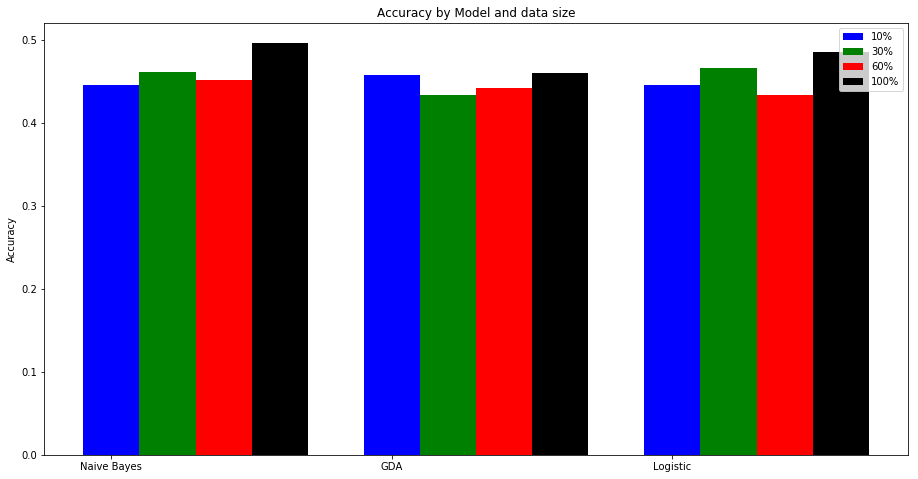

In [51]:
import matplotlib.pyplot as plt

#Names of models
labels = ['Naive Bayes', 'GDA', 'Logistic']

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

#set up the figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])

rects1 = ax.bar(x + 0.00, accuracies[0], width,color = 'b', label='10%')
rects2 = ax.bar(x + .20, accuracies[1], width, color = 'g',label='30%')
rects3 = ax.bar(x + .40, accuracies[2], width, color = 'r',label='60%')
rects4 = ax.bar(x + .60, accuracies[3], width, color = 'k',label='100%')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model and data size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=0)

plt.show()

## Remarks

Generative models
  - GDA p(x|y)
  - Naive Bayes p(x|y)
  
Discriminative model
  - Logistic p(y|x)


GDA works best if the assumption that the features follow a gaussian distribution  hold.

GDA makes stronger modelling assumptions and requires less training data to learn if these modelling assumptions are correct.

Logistic regression makes weaker assumptions. In case the data is non-Gaussian, logistic works better


## Conclusions

Using all the features do not make our models predictive in any way, it rather makes them perform poorly in terms of accuracy.

GDA seems to perform better when the data is 10%. Suprisingly, Naive Bayes and Logistic regression have simillar results when we use 10% of the data. 

It seems like the is no single model that gives outstanding results compared to the others. bIn all the models, the perfomance improves as the data increases.

We can say that GDA is less sensitive to data size while logistic shows that its perfomance is affected by data.

From the observations, the data does not follow a gaussian distribution and hence GDA does not show better results.

Because of the weaker assumptions of logistic regression, it perfoms better compared to GDA  when provided with a good amount of data.


In general, we see that the generative models (i.e Naive Bayes and GDA) are less data sensitive. However, the fact that they need less data to learn is not clearly seen. One reason could be the fact that these models make strong assumptions on the data and the assumptions do not hold.


